In [6]:
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

import operator
event_prefix = 'event000001001'
hits, cells, particles, truth = load_event(os.path.join('train_100_events/', event_prefix))


In [7]:
def cart2spherical(cart):
    r = np.linalg.norm(cart, axis=0)
    theta = np.degrees(np.arccos(cart[2] / r))
    phi = np.degrees(np.arctan2(cart[1], cart[0]))
    return np.vstack((r, theta, phi))

p_traj_list
 [                tx          ty          tz
16553    31.974199   -0.195042  -26.208099
16665    33.904800   -0.213512  -27.874800
23125    71.636299   -0.730313  -60.487900
23144    73.807899   -0.767910  -62.364899
27988   115.115997   -1.682900  -98.077202
32537   171.764999   -3.489160 -147.020996
56364   263.673004   -7.708600 -226.371002
61392   359.229004  -13.918100 -309.011993
66282   499.911011  -26.331200 -431.018005
70681   662.520020  -45.497700 -572.630005
83504   815.025024  -68.311897 -706.318970
87401  1013.080017 -105.017998 -880.945984,                tx          ty           tz
19781   -8.692320  -30.999001   162.130997
25971  -19.328699  -69.395103   371.330994
36324  -30.672400 -111.051003   598.000000
36378  -30.871300 -111.787003   602.000000
38563  -35.633499 -129.455002   698.000000
38630  -35.831299 -130.190994   702.000000
40737  -41.746700 -152.291000   822.000000
75800  -74.093002 -276.632996  1495.500000
76871  -88.076103 -332.147003  1795.500

 [              r       theta       phi
0     41.343102  129.339706 -0.349499
1     43.892887  129.424744 -0.360810
2     93.760750  130.175430 -0.584095
3     96.631134  130.195007 -0.596094
4    151.240417  130.427490 -0.837557
5    226.120682  130.555786 -1.163722
6    347.601349  130.634949 -1.674591
7    474.054413  130.681152 -2.218779
8    660.591309  130.728317 -3.015084
9    876.873962  130.770859 -3.928545
10  1080.656616  130.813705 -4.791088
11  1346.635010  130.857742 -5.918262,               r      theta         phi
0    165.296570  11.231227 -105.663834
1    378.253876  10.978775 -105.564171
2    608.996826  10.904846 -105.440201
3    613.068848  10.904106 -105.438118
4    710.796997  10.888605 -105.389977
5    714.868896  10.888008 -105.388016
6    837.030029  10.874241 -105.329597
7   1522.673828  10.840701 -104.994087
8   1828.086182  10.834361 -104.851433
9   2190.519043  10.830509 -104.695976
10  2597.761475  10.829146 -104.544983
11  3001.965332  10.829728 -104.427

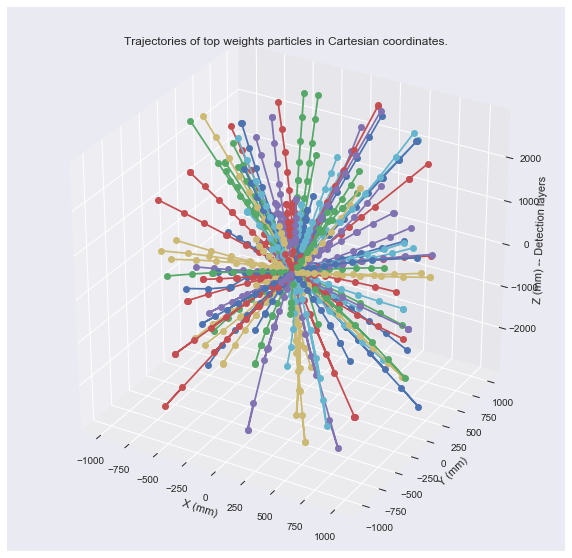

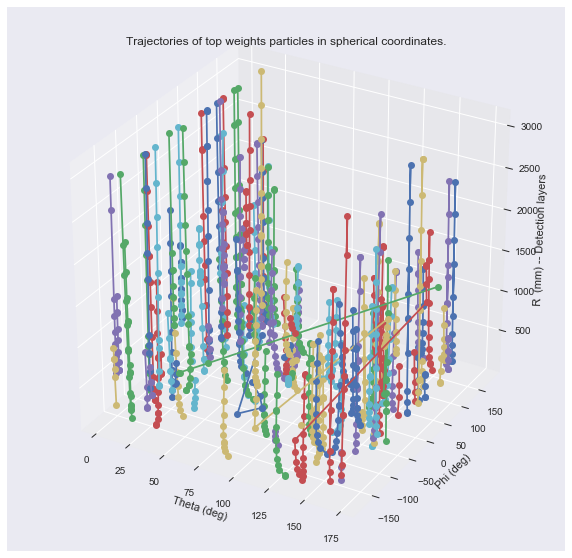

In [27]:
# Get particle id with highest weights
NUM_PARTICLES = 50
truth_dedup = truth.drop_duplicates('particle_id')
truth_sort = truth_dedup.sort_values('weight', ascending=False)
truth_head = truth_sort.iloc[NUM_PARTICLES: 180] #truth_sort.head(NUM_PARTICLES)

# Get points where the same particle intersected subsequent layers of the observation material
p_traj_list = []
for _, tr in truth_head.iterrows():
    p_traj = truth[truth.particle_id == tr.particle_id][['tx', 'ty', 'tz']]
    # Add initial position.
    #p_traj = (p_traj
    #          .append({'tx': particle.vx, 'ty': particle.vy, 'tz': particle.vz}, ignore_index=True)
    #          .sort_values(by='tz'))
    p_traj_list.append(p_traj)
    
print("p_traj_list" "\n", p_traj_list)
    
# Convert to spherical coordinate.
rtp_list = []
for p_traj in p_traj_list:
    xyz = p_traj.loc[:, ['tx', 'ty', 'tz']].values.transpose()
    rtp = cart2spherical(xyz).transpose()
    rtp_df = pd.DataFrame(rtp, columns=('r', 'theta', 'phi'))
    rtp_list.append(rtp_df)
    
print("rtp_list" "\n", rtp_list)

# Plot with Cartesian coordinates.
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for p_traj in p_traj_list:
    ax.plot(
        xs=p_traj.tx,
        ys=p_traj.ty,
        zs=p_traj.tz,
        marker='o')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm) -- Detection layers')
plt.title('Trajectories of top weights particles in Cartesian coordinates.')

# Plot with spherical coordinates.
fig2 = plt.figure(figsize=(10, 10))
ax = fig2.add_subplot(111, projection='3d')
for rtp_df in rtp_list:
    ax.plot(
        xs=rtp_df.theta,
        ys=rtp_df.phi,
        zs=rtp_df.r,
        marker='o')
ax.set_xlabel('Theta (deg)')
ax.set_ylabel('Phi (deg)')
ax.set_zlabel('R  (mm) -- Detection layers')
plt.title('Trajectories of top weights particles in spherical coordinates.')
plt.show()



# for angle in range(0, 360):
#     fig2 = plt.figure(figsize=(10, 10))
#     ax = fig2.add_subplot(111, projection='3d')
#     for rtp_df in rtp_list:
#         ax.plot(
#             xs=rtp_df.theta,
#             ys=rtp_df.phi,
#             zs=rtp_df.r,
#             marker='o')
#     ax.set_xlabel('Theta (deg)')
#     ax.set_ylabel('Phi (deg)')
#     ax.set_zlabel('R  (mm) -- Detection layers')
#     plt.title('Trajectories of top weights particles in spherical coordinates.')
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)
#     plt.show()